In [1]:
from google.colab import drive
import torch
from tqdm import tqdm

drive.mount('mount/')
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
print(device)

Mounted at mount/
cuda:0


In [2]:
from torchvision.transforms.transforms import Resize
import torchvision as tv
import torch.nn.functional as F

transform = tv.transforms.Compose([
            tv.transforms.ToTensor(),
            tv.transforms.Resize(size=64),
            tv.transforms.Normalize(mean = [0.5], std = [0.5])
            ])

batch_size = 256

img_train = tv.datasets.MNIST('mount/MyDrive/MNIST/',train=True,download=True, transform=transform)
img_test = tv.datasets.MNIST('mount/MyDrive/MNIST/',train=False,download=True, transform=transform)

In [3]:
imgtrainDataLoader = torch.utils.data.DataLoader(img_train, batch_size=batch_size,shuffle=True)
imgtestDataLoader = torch.utils.data.DataLoader(img_test, batch_size=batch_size,shuffle=True)

In [4]:
embedding = torch.load('mount/MyDrive/embedding.pt')

In [5]:
# channel
nc = 1
# latent vector
nz = 128
# generator feature maps
ngf = 64
# discriminator feature map
ndf = 64
# gpu
ngpu = 1
# class
n_classes = 10

In [6]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0)

In [7]:
class Generator(torch.nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.label_cg = torch.nn.Sequential(torch.nn.Embedding(n_classes, 100),
                      torch.nn.Linear(100, 16))  

        self.latent = torch.nn.Sequential(torch.nn.Linear(nz, 1*1*1024),
                                    torch.nn.LeakyReLU(0.2, inplace=False))

        self.main = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(1040, ngf * 8, 4, 1, 0, bias=False), # 4, 4
            torch.nn.BatchNorm2d(ngf * 8),
            torch.nn.LeakyReLU(0.2, inplace=False),
            torch.nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False), # 8, 8
            torch.nn.BatchNorm2d(ngf * 4),
            torch.nn.LeakyReLU(0.2, inplace=False),
            torch.nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False), # 16, 16
            torch.nn.BatchNorm2d(ngf * 2),
            torch.nn.LeakyReLU(0.2, inplace=False),
            torch.nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False), # 32, 32
            torch.nn.BatchNorm2d(ngf),
            torch.nn.LeakyReLU(0.2, inplace=False),
            torch.nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False), # 64, 64
            torch.nn.Tanh()
        )

    def forward(self, latent, label):
        label = self.label_cg(label)
        label = label.view(-1, 16, 1, 1)
        latent = self.latent(latent)
        latent = latent.view(-1, 1024, 1, 1)
        concat = torch.cat((latent, label), dim=1)
        return self.main(concat)

#if (device.type == 'cuda') and (ngpu > 1):
    #netG = nn.DataParallel(netG, list(range(ngpu)))

netG = Generator(ngpu).to(device)
netG.label_cg[0].weight.data.copy_(embedding)
netG.apply(weights_init)

Generator(
  (label_cg): Sequential(
    (0): Embedding(10, 100)
    (1): Linear(in_features=100, out_features=16, bias=True)
  )
  (latent): Sequential(
    (0): Linear(in_features=128, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (main): Sequential(
    (0): ConvTranspose2d(1040, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4)

In [8]:
class Discriminator(torch.nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.label_cd = torch.nn.Sequential(torch.nn.Embedding(n_classes, 100),
                                                        torch.nn.Linear(100, 1*64*64))
        self.drop = torch.nn.Dropout(p=0.6, inplace=False)
        self.main = torch.nn.Sequential(
            torch.nn.Conv2d(nc*2, ndf, 4, 2, 1, bias=False), # 64, 64
            torch.nn.BatchNorm2d(ndf),
            torch.nn.LeakyReLU(0.2, inplace=True),
            torch.nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False), # 32, 32
            torch.nn.BatchNorm2d(ndf * 2),
            torch.nn.LeakyReLU(0.2, inplace=True),
            torch.nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False), # 16, 16
            torch.nn.BatchNorm2d(ndf * 4),
            torch.nn.LeakyReLU(0.2, inplace=True),
            torch.nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False), # 4, 4
            torch.nn.BatchNorm2d(ndf * 8),
            torch.nn.LeakyReLU(0.2, inplace=True),
            torch.nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False), # 1, 1
            torch.nn.Sigmoid()
        )

    def forward(self, img, label):
        label = self.label_cd(label)
        label = label.view(-1, 1, 64, 64)
        concat = torch.cat((self.drop(img), label), dim=1)
        #print(concat.size())
        return self.main(concat)

#if (device.type == 'cuda') and (ngpu > 1):
    #netD = nn.DataParallel(netD, list(range(ngpu)))

netD = Discriminator(ngpu).to(device)
netD.label_cd[0].weight.data.copy_(embedding)
netD.apply(weights_init)

Discriminator(
  (label_cd): Sequential(
    (0): Embedding(10, 100)
    (1): Linear(in_features=100, out_features=4096, bias=True)
  )
  (drop): Dropout(p=0.6, inplace=False)
  (main): Sequential(
    (0): Conv2d(2, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(

In [9]:
criterion = torch.nn.BCELoss()

real_label = 1
fake_label = 0

optimizerD = torch.optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999), amsgrad=True)
optimizerG = torch.optim.Adam(netG.parameters(), lr=0.0008, betas=(0.5, 0.999), amsgrad=True)

torch.autograd.set_detect_anomaly(False)

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def plot(img):
    plt.style.use('dark_background')
    plt.subplot(1,2,2)
    plt.axis("off")
    plt.title("fake images")
    plt.imshow(np.transpose(img.cpu(),(1,2,0)))
    plt.show()

In [11]:
G_loss = []
D_loss = []
num = 50

netG.zero_grad()
print("Starting Training Loop...")
for epoch in range(num):
    eD, eG, D_x, D_G_z1, D_G_z2 = 0, 0, 0, 0, 0
    for i, data in enumerate(tqdm(imgtrainDataLoader)):
        real_cpu, tag = data
        real_cpu = real_cpu.to(device)
        tag = tag.to(device).unsqueeze(1).long()
        b_size = data[0].size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float).to(device)

        noise = torch.randn(b_size, nz).to(device)
        fake = netG(noise, tag)
        fake.detach()

        netD.zero_grad()
        output = netD(real_cpu, tag).squeeze()
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x += output.mean().item()

        label.fill_(fake_label)
        output = netD(fake, tag).squeeze()
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 += output.mean().item()
        errD = errD_real + errD_fake
        eD += errD
        optimizerD.step()

        netG.zero_grad()
        label.fill_(real_label)
        fake = netG(noise, tag)
        output = netD(fake, tag).squeeze()
        errG = criterion(output, label)
        eG += errG
        errG.backward()
        D_G_z2 += output.mean().item()
        optimizerG.step()
        netG.zero_grad()

    D_loss.append(eD.data.cpu().numpy()/len(imgtrainDataLoader))
    G_loss.append(eG.data.cpu().numpy()/len(imgtrainDataLoader))

    print('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
            % (epoch, num,
            eD/len(imgtrainDataLoader), eG/len(imgtrainDataLoader),
            D_x/len(imgtrainDataLoader), D_G_z1/len(imgtrainDataLoader), D_G_z2/len(imgtrainDataLoader)))

Starting Training Loop...


100%|██████████| 235/235 [02:25<00:00,  1.61it/s]


[0/50]	Loss_D: 1.9081	Loss_G: 5.4935	D(x): 0.5881	D(G(z)): 0.4095 / 0.0272


100%|██████████| 235/235 [02:28<00:00,  1.58it/s]


[1/50]	Loss_D: 0.9108	Loss_G: 5.0942	D(x): 0.7613	D(G(z)): 0.2365 / 0.0292


100%|██████████| 235/235 [02:29<00:00,  1.57it/s]


[2/50]	Loss_D: 0.7012	Loss_G: 3.2759	D(x): 0.7693	D(G(z)): 0.2232 / 0.0710


100%|██████████| 235/235 [02:29<00:00,  1.57it/s]


[3/50]	Loss_D: 0.5571	Loss_G: 3.2053	D(x): 0.8109	D(G(z)): 0.1855 / 0.0941


100%|██████████| 235/235 [02:29<00:00,  1.57it/s]


[4/50]	Loss_D: 0.8650	Loss_G: 2.3261	D(x): 0.7168	D(G(z)): 0.2820 / 0.1749


100%|██████████| 235/235 [02:29<00:00,  1.57it/s]


[5/50]	Loss_D: 1.0938	Loss_G: 1.5632	D(x): 0.6333	D(G(z)): 0.3637 / 0.2697


100%|██████████| 235/235 [02:29<00:00,  1.57it/s]


[6/50]	Loss_D: 1.0778	Loss_G: 1.5320	D(x): 0.6355	D(G(z)): 0.3616 / 0.2773


100%|██████████| 235/235 [02:29<00:00,  1.57it/s]


[7/50]	Loss_D: 1.1082	Loss_G: 1.4390	D(x): 0.6243	D(G(z)): 0.3749 / 0.2933


100%|██████████| 235/235 [02:29<00:00,  1.57it/s]


[8/50]	Loss_D: 1.0788	Loss_G: 1.4770	D(x): 0.6334	D(G(z)): 0.3638 / 0.2921


100%|██████████| 235/235 [02:29<00:00,  1.57it/s]


[9/50]	Loss_D: 1.0657	Loss_G: 1.5479	D(x): 0.6400	D(G(z)): 0.3586 / 0.2802


100%|██████████| 235/235 [02:29<00:00,  1.57it/s]


[10/50]	Loss_D: 1.0926	Loss_G: 1.4754	D(x): 0.6302	D(G(z)): 0.3683 / 0.2926


100%|██████████| 235/235 [02:29<00:00,  1.57it/s]


[11/50]	Loss_D: 1.0559	Loss_G: 1.4525	D(x): 0.6370	D(G(z)): 0.3610 / 0.2925


100%|██████████| 235/235 [02:29<00:00,  1.57it/s]


[12/50]	Loss_D: 1.0652	Loss_G: 1.4557	D(x): 0.6357	D(G(z)): 0.3625 / 0.2931


100%|██████████| 235/235 [02:29<00:00,  1.57it/s]


[13/50]	Loss_D: 1.0153	Loss_G: 1.5534	D(x): 0.6510	D(G(z)): 0.3482 / 0.2712


100%|██████████| 235/235 [02:29<00:00,  1.57it/s]


[14/50]	Loss_D: 1.0002	Loss_G: 1.5849	D(x): 0.6546	D(G(z)): 0.3427 / 0.2641


100%|██████████| 235/235 [02:29<00:00,  1.57it/s]


[15/50]	Loss_D: 0.9995	Loss_G: 1.5926	D(x): 0.6577	D(G(z)): 0.3400 / 0.2677


100%|██████████| 235/235 [02:29<00:00,  1.57it/s]


[16/50]	Loss_D: 0.9628	Loss_G: 1.6660	D(x): 0.6691	D(G(z)): 0.3301 / 0.2508


100%|██████████| 235/235 [02:29<00:00,  1.57it/s]


[17/50]	Loss_D: 0.9239	Loss_G: 1.7277	D(x): 0.6786	D(G(z)): 0.3200 / 0.2374


100%|██████████| 235/235 [02:29<00:00,  1.57it/s]


[18/50]	Loss_D: 0.9492	Loss_G: 1.7616	D(x): 0.6783	D(G(z)): 0.3197 / 0.2411


100%|██████████| 235/235 [02:29<00:00,  1.57it/s]


[19/50]	Loss_D: 0.9913	Loss_G: 1.6279	D(x): 0.6637	D(G(z)): 0.3350 / 0.2608


100%|██████████| 235/235 [02:29<00:00,  1.57it/s]


[20/50]	Loss_D: 0.9315	Loss_G: 1.7410	D(x): 0.6776	D(G(z)): 0.3190 / 0.2353


100%|██████████| 235/235 [02:29<00:00,  1.58it/s]


[21/50]	Loss_D: 0.9671	Loss_G: 1.6815	D(x): 0.6725	D(G(z)): 0.3265 / 0.2539


100%|██████████| 235/235 [02:29<00:00,  1.57it/s]


[22/50]	Loss_D: 0.9496	Loss_G: 1.6731	D(x): 0.6721	D(G(z)): 0.3262 / 0.2483


100%|██████████| 235/235 [02:29<00:00,  1.57it/s]


[23/50]	Loss_D: 0.9293	Loss_G: 1.7225	D(x): 0.6827	D(G(z)): 0.3161 / 0.2453


100%|██████████| 235/235 [02:29<00:00,  1.57it/s]


[24/50]	Loss_D: 0.9066	Loss_G: 1.7510	D(x): 0.6883	D(G(z)): 0.3110 / 0.2385


100%|██████████| 235/235 [02:29<00:00,  1.57it/s]


[25/50]	Loss_D: 0.9213	Loss_G: 1.7745	D(x): 0.6849	D(G(z)): 0.3130 / 0.2329


100%|██████████| 235/235 [02:29<00:00,  1.57it/s]


[26/50]	Loss_D: 0.9117	Loss_G: 1.7287	D(x): 0.6847	D(G(z)): 0.3124 / 0.2402


100%|██████████| 235/235 [02:29<00:00,  1.57it/s]


[27/50]	Loss_D: 0.8319	Loss_G: 1.9131	D(x): 0.7114	D(G(z)): 0.2878 / 0.2117


100%|██████████| 235/235 [02:29<00:00,  1.57it/s]


[28/50]	Loss_D: 0.8835	Loss_G: 1.8975	D(x): 0.7004	D(G(z)): 0.2979 / 0.2225


100%|██████████| 235/235 [02:29<00:00,  1.57it/s]


[29/50]	Loss_D: 0.9011	Loss_G: 1.7846	D(x): 0.6918	D(G(z)): 0.3069 / 0.2319


100%|██████████| 235/235 [02:29<00:00,  1.57it/s]


[30/50]	Loss_D: 0.8936	Loss_G: 1.7795	D(x): 0.6924	D(G(z)): 0.3066 / 0.2351


100%|██████████| 235/235 [02:29<00:00,  1.57it/s]


[31/50]	Loss_D: 0.8464	Loss_G: 1.8850	D(x): 0.7073	D(G(z)): 0.2901 / 0.2174


100%|██████████| 235/235 [02:29<00:00,  1.57it/s]


[32/50]	Loss_D: 0.8950	Loss_G: 1.8430	D(x): 0.6962	D(G(z)): 0.3040 / 0.2308


100%|██████████| 235/235 [02:29<00:00,  1.57it/s]


[33/50]	Loss_D: 0.8773	Loss_G: 1.8329	D(x): 0.6984	D(G(z)): 0.2992 / 0.2256


100%|██████████| 235/235 [02:29<00:00,  1.57it/s]


[34/50]	Loss_D: 0.8836	Loss_G: 1.8549	D(x): 0.6978	D(G(z)): 0.3021 / 0.2227


100%|██████████| 235/235 [02:29<00:00,  1.57it/s]


[35/50]	Loss_D: 0.8797	Loss_G: 1.7945	D(x): 0.6987	D(G(z)): 0.2992 / 0.2315


100%|██████████| 235/235 [02:29<00:00,  1.57it/s]


[36/50]	Loss_D: 0.9090	Loss_G: 1.7769	D(x): 0.6928	D(G(z)): 0.3067 / 0.2381


100%|██████████| 235/235 [02:29<00:00,  1.57it/s]


[37/50]	Loss_D: 0.8626	Loss_G: 1.8024	D(x): 0.7024	D(G(z)): 0.2973 / 0.2310


100%|██████████| 235/235 [02:29<00:00,  1.57it/s]


[38/50]	Loss_D: 0.8725	Loss_G: 1.8547	D(x): 0.7019	D(G(z)): 0.2960 / 0.2227


100%|██████████| 235/235 [02:29<00:00,  1.57it/s]


[39/50]	Loss_D: 0.8413	Loss_G: 1.9019	D(x): 0.7101	D(G(z)): 0.2887 / 0.2130


100%|██████████| 235/235 [02:29<00:00,  1.57it/s]


[40/50]	Loss_D: 0.8509	Loss_G: 1.9010	D(x): 0.7102	D(G(z)): 0.2887 / 0.2176


100%|██████████| 235/235 [02:29<00:00,  1.57it/s]


[41/50]	Loss_D: 0.7988	Loss_G: 1.9541	D(x): 0.7210	D(G(z)): 0.2759 / 0.2065


100%|██████████| 235/235 [02:29<00:00,  1.57it/s]


[42/50]	Loss_D: 0.8718	Loss_G: 1.9205	D(x): 0.7067	D(G(z)): 0.2929 / 0.2167


100%|██████████| 235/235 [02:29<00:00,  1.57it/s]


[43/50]	Loss_D: 0.8574	Loss_G: 1.9105	D(x): 0.7085	D(G(z)): 0.2907 / 0.2185


100%|██████████| 235/235 [02:29<00:00,  1.57it/s]


[44/50]	Loss_D: 0.8198	Loss_G: 1.9244	D(x): 0.7168	D(G(z)): 0.2824 / 0.2118


100%|██████████| 235/235 [02:29<00:00,  1.57it/s]


[45/50]	Loss_D: 0.8244	Loss_G: 1.9087	D(x): 0.7141	D(G(z)): 0.2842 / 0.2132


100%|██████████| 235/235 [02:29<00:00,  1.57it/s]


[46/50]	Loss_D: 0.8611	Loss_G: 1.8796	D(x): 0.7074	D(G(z)): 0.2919 / 0.2216


100%|██████████| 235/235 [02:29<00:00,  1.57it/s]


[47/50]	Loss_D: 0.8250	Loss_G: 1.9191	D(x): 0.7151	D(G(z)): 0.2829 / 0.2113


100%|██████████| 235/235 [02:29<00:00,  1.57it/s]


[48/50]	Loss_D: 0.8174	Loss_G: 1.9998	D(x): 0.7214	D(G(z)): 0.2775 / 0.2030


100%|██████████| 235/235 [02:29<00:00,  1.57it/s]

[49/50]	Loss_D: 0.8328	Loss_G: 1.9207	D(x): 0.7139	D(G(z)): 0.2842 / 0.2171


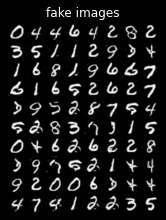

In [12]:
torch.save(netG.state_dict(), 'mount/MyDrive/gen.pt')
plot(tv.utils.make_grid(fake[:-16], padding=2, normalize=True).cpu())

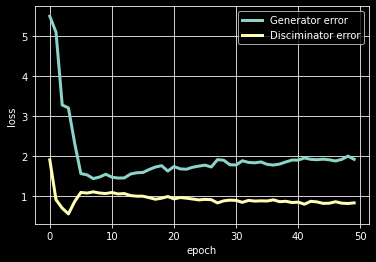

In [13]:
import matplotlib.pyplot as plt

plt.style.use('dark_background')
plt.plot(range(len(G_loss)),G_loss,'-',linewidth=3,label='Generator error')
plt.plot(range(len(D_loss)),D_loss,'-',linewidth=3,label='Disciminator error')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()